In [1]:
import sys
sys.path.insert(0, "/Users/aimachine/PyImage/utils")
import numpy as np
import tensorflow as tf
import importlib
import matplotlib.pyplot as plt
import os
import glob
import skimage
import cv2

from skimage import measure
from skimage import filters
from sklearn.cluster import DBSCAN
from skimage.filters import threshold_otsu
from tifffile import imread
import scipy
from PIL import Image
from skimage.filters.rank import median
from scipy import ndimage
from scipy.ndimage.filters import median_filter
from DBScan import segment_dbscan,show_clusters_DBSCAN
from DiscreteClustering import Discretize_Clustering
from Normalize import normalizeFloat, normalizeMinMax, Path, save_tiff_imagej_compatible

/Users/aimachine/anaconda3/envs/tensorflowpy3pt5/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/aimachine/anaconda3/envs/tensorflowpy3pt5/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/aimachine/anaconda3/envs/tensorflowpy3pt5/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/aimachine/anaconda3/envs/tensorflowpy3pt5/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/aimachine/anaconda3/envs/tensorflowpy3pt5/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed

In [2]:
basedir = '/Users/aimachine/Documents/JuliaData/Julia/Subset/OzRawMedian/'
targetdir = '/Users/aimachine/Documents/JuliaData/Julia/Subset/OzRawMedian/Result/'

In [3]:
Path = os.path.join(basedir, '*.tif')
X = []
Names = []
filesRaw = glob.glob(Path)
maxtime = 0
axes = 'TYX'
for fname in filesRaw:
      x = imread(fname)
      min = np.amin(x)
      max = np.amax(x)
      x = normalizeMinMax(x, min, max)  
      
      X.append(x)
    
     
      Names.append(fname)
      if X[0].shape[0] > maxtime:
        maxtime = X[0].shape[0]
X.sort
Names.sort


ReshapeX = []
for i in range(len(X)):
    y = np.zeros((maxtime, X[0].shape[1], X[0].shape[2]))
    image = X[i]
    
    y[:X[i].shape[0],:,:] = image[:,:,:]
    ReshapeX.append(y)
    
ReshapeX.sort

print('Total number of input images = ', len(X))
print('Image size = ', X[0].shape)
print('Time dim = ', maxtime)

timerange = maxtime

doDBscan = True
doClustering = False

Total number of input images =  1
Image size =  (241, 267, 266)
Time dim =  241


In [4]:
def Clustering(img):
    Labels = img
    T_REGIONS = []
    for j in range(timerange):
      smallimg = img[j,:,:]
      
      """Put clustering code"""
      
      labels, N_REGIONS =Discretize_Clustering(smallimg, N_REGIONS = 150)
      Labels[j,:,:] = labels
      T_REGIONS.append( N_REGIONS)  
    return Labels, T_REGIONS       

    
       
    
    

In [5]:
def DBScan(img):
    
    
    
    segmentation_params = {
        "IntensityThreshold": 45,
        "BlurKernelSize": 3,
        "BlurSigma": 1,

        "Clustering": {
            "Eps": 10,
            "MinDensity": 70,
            "BorderPoints": 1,

            "KdTree": {
                "BucketSize": 20,
                "SplitRule": 4,
                "Approx": 0
            }
        },
    }
    Labels = img
    Clusters = []
    for j in range(timerange):
      smallimg = img[j,:,:]
      
      medianimg = median_filter(smallimg, size = 5)
      cluster_list, cluster_image = segment_dbscan(medianimg, segmentation_params)
      Labels[j,:,:] = cluster_image;  
      Clusters.append(cluster_list)
    return Labels, Clusters     

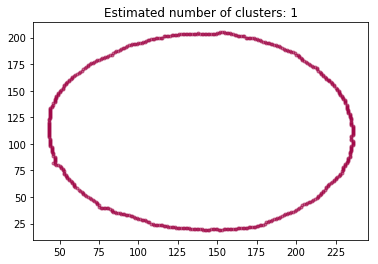

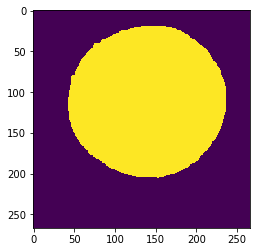

/Users/aimachine/PyImage/utils/Normalize.py:48: UserWarning: Converting data type from 'float64' to ImageJ-compatible 'float32'.
  warnings.warn("Converting data type from '%s' to ImageJ-compatible '%s'." % (t, np.dtype(t_new)))
/Users/aimachine/PyImage/utils/Normalize.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  x = x[slices]


In [6]:
for i in range(0, len(ReshapeX)):
  newimg = ReshapeX[i]
  if doDBscan:
    Labels, Clusters = DBScan(newimg)
    
    plt.figure(1)
    show_clusters_DBSCAN(newimg, Clusters[i])

    plt.figure(2)
    plt.imshow(Labels[i])
    plt.show()
    save_tiff_imagej_compatible((targetdir + 'Result' + os.path.basename(Names[i])) , Labels, axes)
  if doClustering:
    Labels, T_REGIONS = Clustering(newimg)
    plt.figure(figsize=(5, 5))
    plt.imshow(newimg[0,:,:])
    plt.figure(figsize=(5, 5))
    plt.imshow(newimg[0,:,:])
    N_REGIONS = T_REGIONS[0]
    labels = Labels[0,:,:]
    for l in range(N_REGIONS):
        
        plt.contour(labels == l, contours=1,
                    colors=[plt.cm.nipy_spectral(l / float(N_REGIONS)), ])